In [1]:
import os
import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18, ResNet18_Weights
import numpy as np

# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
NUM_CLASSES = 2
N_MELS = 128
TARGET_SR = 16000

def extract_mel_spectrogram(file_path, n_mels=N_MELS, max_length=None):
    """
    Extract mel spectrogram from audio file with robust error handling
    """
    try:
        waveform, sample_rate = torchaudio.load(file_path)
        
        # Resample if needed
        if sample_rate != TARGET_SR:
            resampler = torchaudio.transforms.Resample(sample_rate, TARGET_SR)
            waveform = resampler(waveform)
        
        # Mono conversion
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        
        mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=TARGET_SR,
            n_mels=n_mels,
            n_fft=2048,
            hop_length=512
        )(waveform)
        
        # Convert to decibels
        mel_spectrogram = torchaudio.transforms.AmplitudeToDB()(mel_spectrogram)
        
        # Normalize
        mel_spectrogram = (mel_spectrogram - mel_spectrogram.mean()) / mel_spectrogram.std()
        
        # Pad or truncate to fixed length
        if max_length:
            if mel_spectrogram.shape[2] > max_length:
                mel_spectrogram = mel_spectrogram[:, :, :max_length]
            else:
                padding = max_length - mel_spectrogram.shape[2]
                mel_spectrogram = torch.nn.functional.pad(mel_spectrogram, (0, padding))
        
        return mel_spectrogram.squeeze(0)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

class ASVspoofDataset(Dataset):
    def __init__(self, data_dir, protocol_file, transform=None, max_length=None):
        self.data_dir = data_dir
        self.transform = transform
        self.max_length = max_length
        self.labels = {}
        
        # Read protocol file
        with open(protocol_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                audio_id = parts[1]
                label = 0 if parts[-1] == "bonafide" else 1
                self.labels[audio_id] = label
        
        # Filter valid audio files
        self.audio_files = [
            f for f in os.listdir(data_dir) 
            if f.endswith('.flac') and f.replace('.flac', '') in self.labels
        ]
    
    def __len__(self):
        return len(self.audio_files)
    
    def __getitem__(self, idx):
        audio_file = self.audio_files[idx]
        file_path = os.path.join(self.data_dir, audio_file)
        
        mel_spectrogram = extract_mel_spectrogram(
            file_path, 
            max_length=self.max_length
        )
        
        # Handle potential processing errors
        if mel_spectrogram is None:
            # Return a dummy tensor and label to avoid breaking DataLoader
            return torch.zeros(1, N_MELS, N_MELS), 0
        
        label = self.labels[audio_file.replace('.flac', '')]
        return mel_spectrogram, label

def train_model(train_loader, val_loader):
    """
    Train ResNet18 for audio deepfake detection with local weights
    """
    try:
        # Use local weights or default if download fails
        model = resnet18(weights=ResNet18_Weights.DEFAULT)
    except Exception as e:
        print(f"Failed to download weights: {e}")
        model = resnet18(weights=None)
    
    # Modify for single-channel and binary classification
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    model = model.to(DEVICE)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    for epoch in range(NUM_EPOCHS):
        model.train()
        train_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.unsqueeze(1).to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.unsqueeze(1).to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
        print(f"Train Loss: {train_loss/len(train_loader):.4f}")
        print(f"Val Loss: {val_loss/len(val_loader):.4f}")
        print(f"Val Accuracy: {100 * correct / total:.2f}%")
    
    return model

def export_model(model, output_path):
    """
    Export model to ONNX for cross-platform compatibility
    """
    dummy_input = torch.randn(1, 1, N_MELS, N_MELS).to(DEVICE)
    torch.onnx.export(
        model, 
        dummy_input, 
        output_path,
        opset_version=11,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
    )

def main():
    # Dataset paths (replace with your actual paths)
    TRAIN_PATH = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_train/flac"
    DEV_PATH = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_dev/flac"
    PROTOCOL_PATH = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols"
    
    # Create datasets
    train_dataset = ASVspoofDataset(
        TRAIN_PATH, 
        os.path.join(PROTOCOL_PATH, "ASVspoof2019.LA.cm.train.trn.txt"),
        max_length=N_MELS
    )
    
    dev_dataset = ASVspoofDataset(
        DEV_PATH, 
        os.path.join(PROTOCOL_PATH, "ASVspoof2019.LA.cm.dev.trl.txt"),
        max_length=N_MELS
    )
    
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)
    
    # Train model
    trained_model = train_model(train_loader, dev_loader)
    
    # Export model
    export_model(trained_model, "deepfake_audio_detector.onnx")

if __name__ == "__main__":
    main()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 160MB/s]


Epoch 1/10
Train Loss: 0.0361
Val Loss: 0.0011
Val Accuracy: 99.97%
Epoch 2/10
Train Loss: 0.0043
Val Loss: 0.0022
Val Accuracy: 99.94%
Epoch 3/10
Train Loss: 0.0004
Val Loss: 0.0016
Val Accuracy: 99.95%
Epoch 4/10
Train Loss: 0.0033
Val Loss: 0.0055
Val Accuracy: 99.75%
Epoch 5/10
Train Loss: 0.0003
Val Loss: 0.0003
Val Accuracy: 99.99%
Epoch 6/10
Train Loss: 0.0017
Val Loss: 0.0009
Val Accuracy: 99.98%
Epoch 7/10
Train Loss: 0.0016
Val Loss: 0.0006
Val Accuracy: 99.98%
Epoch 8/10
Train Loss: 0.0020
Val Loss: 0.0004
Val Accuracy: 99.99%
Epoch 9/10
Train Loss: 0.0002
Val Loss: 0.0006
Val Accuracy: 99.98%
Epoch 10/10
Train Loss: 0.0010
Val Loss: 0.0033
Val Accuracy: 99.88%


In [1]:
import os
import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18, ResNet18_Weights
import numpy as np

# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 30
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_CLASSES = 2
N_MELS = 128
TARGET_SR = 16000

def extract_mel_spectrogram(file_path, n_mels=N_MELS, max_length=None):
    """
    Extract mel spectrogram from audio file with robust error handling
    """
    try:
        waveform, sample_rate = torchaudio.load(file_path)
        
        # Resample if needed
        if sample_rate != TARGET_SR:
            resampler = torchaudio.transforms.Resample(sample_rate, TARGET_SR)
            waveform = resampler(waveform)
        
        # Mono conversion
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        
        mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=TARGET_SR,
            n_mels=n_mels,
            n_fft=2048,
            hop_length=512
        )(waveform)
        
        # Convert to decibels
        mel_spectrogram = torchaudio.transforms.AmplitudeToDB()(mel_spectrogram)
        
        # Normalize
        mel_spectrogram = (mel_spectrogram - mel_spectrogram.mean()) / mel_spectrogram.std()
        
        # Pad or truncate to fixed length
        if max_length:
            if mel_spectrogram.shape[2] > max_length:
                mel_spectrogram = mel_spectrogram[:, :, :max_length]
            else:
                padding = max_length - mel_spectrogram.shape[2]
                mel_spectrogram = torch.nn.functional.pad(mel_spectrogram, (0, padding))
        
        return mel_spectrogram.squeeze(0)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

class ASVspoofDataset(Dataset):
    def __init__(self, data_dir, protocol_file, transform=None, max_length=None):
        self.data_dir = data_dir
        self.transform = transform
        self.max_length = max_length
        self.labels = {}
        
        # Read protocol file
        with open(protocol_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                audio_id = parts[1]
                label = 0 if parts[-1] == "bonafide" else 1
                self.labels[audio_id] = label
        
        # Filter valid audio files
        self.audio_files = [
            f for f in os.listdir(data_dir) 
            if f.endswith('.flac') and f.replace('.flac', '') in self.labels
        ]
    
    def __len__(self):
        return len(self.audio_files)
    
    def __getitem__(self, idx):
        audio_file = self.audio_files[idx]
        file_path = os.path.join(self.data_dir, audio_file)
        
        mel_spectrogram = extract_mel_spectrogram(
            file_path, 
            max_length=self.max_length
        )
        
        # Handle potential processing errors
        if mel_spectrogram is None:
            # Return a dummy tensor and label to avoid breaking DataLoader
            return torch.zeros(1, N_MELS, N_MELS), 0
        
        label = self.labels[audio_file.replace('.flac', '')]
        return mel_spectrogram, label

def train_model(train_loader, val_loader):
    """
    Train ResNet18 for audio deepfake detection with local weights
    """
    try:
        # Use local weights or default if download fails
        model = resnet18(weights=ResNet18_Weights.DEFAULT)
    except Exception as e:
        print(f"Failed to download weights: {e}")
        model = resnet18(weights=None)
    
    # Modify for single-channel and binary classification
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    model = model.to(DEVICE)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    for epoch in range(NUM_EPOCHS):
        model.train()
        train_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.unsqueeze(1).to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.unsqueeze(1).to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
        print(f"Train Loss: {train_loss/len(train_loader):.4f}")
        print(f"Val Loss: {val_loss/len(val_loader):.4f}")
        print(f"Val Accuracy: {100 * correct / total:.2f}%")
    
    return model

def export_model(model, output_path):
    """
    Export model to ONNX for cross-platform compatibility
    """
    dummy_input = torch.randn(1, 1, N_MELS, N_MELS).to(DEVICE)
    torch.onnx.export(
        model, 
        dummy_input, 
        output_path,
        opset_version=11,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
    )

def main():
    # Dataset paths (replace with your actual paths)
    TRAIN_PATH = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_train/flac"
    DEV_PATH = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_dev/flac"
    PROTOCOL_PATH = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols"
    
    # Create datasets
    train_dataset = ASVspoofDataset(
        TRAIN_PATH, 
        os.path.join(PROTOCOL_PATH, "ASVspoof2019.LA.cm.train.trn.txt"),
        max_length=N_MELS
    )
    
    dev_dataset = ASVspoofDataset(
        DEV_PATH, 
        os.path.join(PROTOCOL_PATH, "ASVspoof2019.LA.cm.dev.trl.txt"),
        max_length=N_MELS
    )
    
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)
    
    # Train model
    trained_model = train_model(train_loader, dev_loader)
    
    # Export model
    export_model(trained_model, "deepfake_audio_detector.onnx")

if __name__ == "__main__":
    main()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 170MB/s] 


Epoch 1/30
Train Loss: 0.0263
Val Loss: 0.0111
Val Accuracy: 99.78%
Epoch 2/30
Train Loss: 0.0079
Val Loss: 0.0022
Val Accuracy: 99.92%
Epoch 3/30
Train Loss: 0.0047
Val Loss: 0.0010
Val Accuracy: 99.98%
Epoch 4/30
Train Loss: 0.0003
Val Loss: 0.0010
Val Accuracy: 99.96%
Epoch 5/30
Train Loss: 0.0028
Val Loss: 0.0103
Val Accuracy: 99.75%
Epoch 6/30
Train Loss: 0.0056
Val Loss: 0.0016
Val Accuracy: 99.94%
Epoch 7/30
Train Loss: 0.0029
Val Loss: 0.0054
Val Accuracy: 99.79%
Epoch 8/30
Train Loss: 0.0010
Val Loss: 0.0045
Val Accuracy: 99.82%
Epoch 9/30
Train Loss: 0.0020
Val Loss: 0.0088
Val Accuracy: 99.75%
Epoch 10/30
Train Loss: 0.0008
Val Loss: 0.0003
Val Accuracy: 99.99%
Epoch 11/30
Train Loss: 0.0042
Val Loss: 0.0023
Val Accuracy: 99.91%
Epoch 12/30
Train Loss: 0.0145
Val Loss: 0.0010
Val Accuracy: 99.97%
Epoch 13/30
Train Loss: 0.0030
Val Loss: 0.0004
Val Accuracy: 99.99%
Epoch 14/30
Train Loss: 0.0002
Val Loss: 0.0004
Val Accuracy: 99.99%
Epoch 15/30
Train Loss: 0.0000
Val Loss: 0.

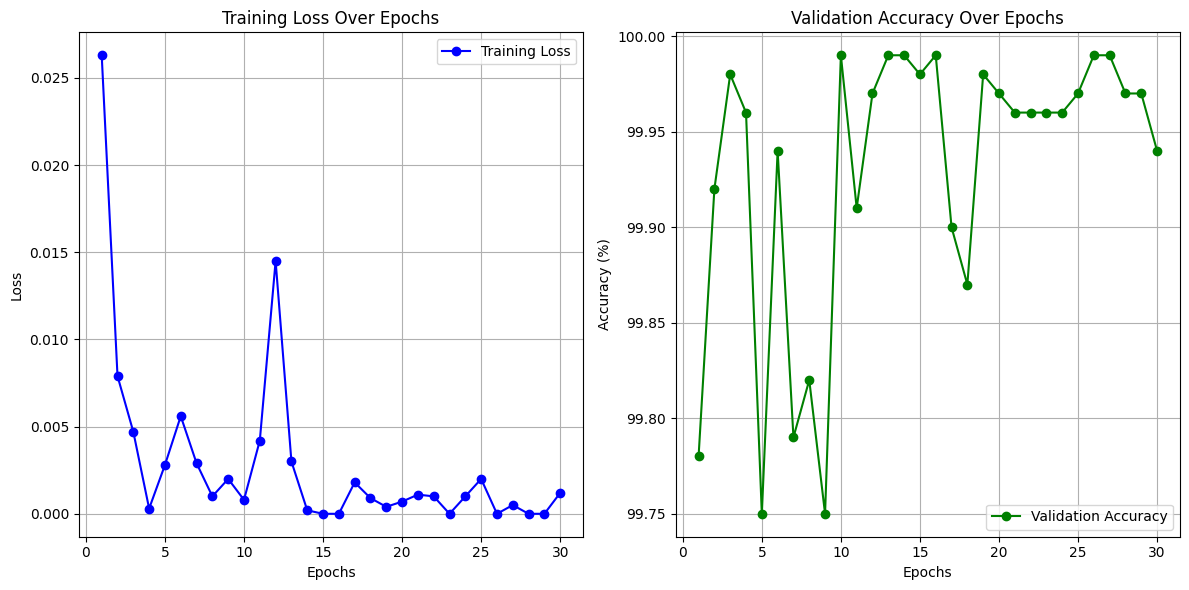

In [1]:
import matplotlib.pyplot as plt

# Example data (Replace with your collected values during training)
train_losses = [
    0.0263, 0.0079, 0.0047, 0.0003, 0.0028, 0.0056, 0.0029, 0.0010, 0.0020, 0.0008, 
    0.0042, 0.0145, 0.0030, 0.0002, 0.0000, 0.0000, 0.0018, 0.0009, 0.0004, 0.0007, 
    0.0011, 0.0010, 0.0000, 0.0010, 0.0020, 0.0000, 0.0005, 0.0000, 0.0000, 0.0012
]
val_accuracies = [
    99.78, 99.92, 99.98, 99.96, 99.75, 99.94, 99.79, 99.82, 99.75, 99.99,
    99.91, 99.97, 99.99, 99.99, 99.98, 99.99, 99.90, 99.87, 99.98, 99.97,
    99.96, 99.96, 99.96, 99.96, 99.97, 99.99, 99.99, 99.97, 99.97, 99.94
]

epochs = list(range(1, 31))

# Plotting Training Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Training Loss", marker='o', color='b')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid(True)
plt.legend()

# Plotting Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label="Validation Accuracy", marker='o', color='g')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy Over Epochs")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


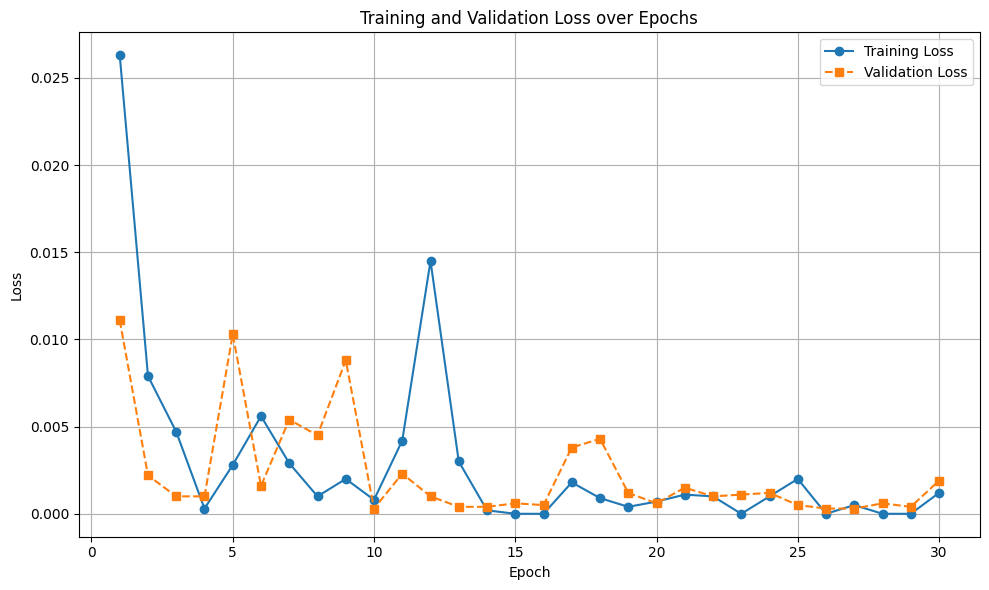

In [2]:
import matplotlib.pyplot as plt

# Training and validation losses
train_losses = [
    0.0263, 0.0079, 0.0047, 0.0003, 0.0028, 0.0056, 0.0029, 0.0010, 0.0020, 0.0008,
    0.0042, 0.0145, 0.0030, 0.0002, 0.0000, 0.0000, 0.0018, 0.0009, 0.0004, 0.0007,
    0.0011, 0.0010, 0.0000, 0.0010, 0.0020, 0.0000, 0.0005, 0.0000, 0.0000, 0.0012
]

val_losses = [
    0.0111, 0.0022, 0.0010, 0.0010, 0.0103, 0.0016, 0.0054, 0.0045, 0.0088, 0.0003,
    0.0023, 0.0010, 0.0004, 0.0004, 0.0006, 0.0005, 0.0038, 0.0043, 0.0012, 0.0006,
    0.0015, 0.0010, 0.0011, 0.0012, 0.0005, 0.0003, 0.0003, 0.0006, 0.0004, 0.0019
]

# Plotting the losses
epochs = range(1, 31)  # 30 epochs

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, val_losses, label='Validation Loss', marker='s', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
def train_model(train_loader, val_loader):
    """
    Train ResNet18 for audio deepfake detection with local weights
    """
    try:
        # Use local weights or default if download fails
        model = resnet18(weights=ResNet18_Weights.DEFAULT)
    except Exception as e:
        print(f"Failed to download weights: {e}")
        model = resnet18(weights=None)
    
    # Modify for single-channel and binary classification
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    model = model.to(DEVICE)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(NUM_EPOCHS):
        model.train()
        train_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.unsqueeze(1).to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.unsqueeze(1).to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}")
    
    return model, train_losses, val_losses
